In [3]:
# Import Packages

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import mapclassify
import plotly.express as px
from shapely.geometry import Point
import contextily as cx
from pysal.lib import weights
from pysal.explore import esda
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster

### Crime Points Code

In [4]:
# Reading CRIME POINTS file

crimepoints = pd.read_csv('crimepoints.csv')
crimepoints.head(5)


Crime ID    Month  \
0  59263678a3b555ff49b56c8139a50ae7d726319ad11696...  2021-03   
1  b76e47ab9e47e04e113d39a07e5d98ebe26573e2e59c87...  2021-03   
2  eb03022d768846e0205cb1085ac26f657d522b5d391779...  2021-03   
3  cb8731ed3a2baf3ea4bb652a2049b3bc407dbbf73d19ee...  2021-03   
4  51e6cadbbe32c9edcd77d9be18ab0bf0e133e07d026b54...  2021-03   

             Reported by           Falls within  Longitude   Latitude  \
0  City of London Police  City of London Police  -0.126375  51.531512   
1  City of London Police  City of London Police  -0.109582  51.522017   
2  City of London Police  City of London Police  -0.109582  51.522017   
3  City of London Police  City of London Police  -0.111497  51.518226   
4  City of London Police  City of London Police  -0.111497  51.518226   

                       Location  LSOA code    LSOA name  \
0      On or near Shopping Area  E01000953  Camden 022B   
1   On or near Clerkenwell Road  E01000916  Camden 027B   
2   On or near Clerkenwell Road  E01000916  Camden 027B   
3  On or near Pedestrian Subway  E01000914  Camden 028B   
4  On or near Pedestrian Subway  E01000914  Camden 028B   

                     Crime type  \
0  Violence and sexual offences   
1                         Drugs   
2         Possession of weapons   
3                      Burglary   
4                   Other theft   

                           Last outcome category  Context  
0                      Status update unavailable      NaN  
1                      Status update unavailable      NaN  
2                      Status update unavailable      NaN  
3  Investigation complete; no suspect identified      NaN  
4  Investigation complete; no suspect identified      NaN

<Axes: >

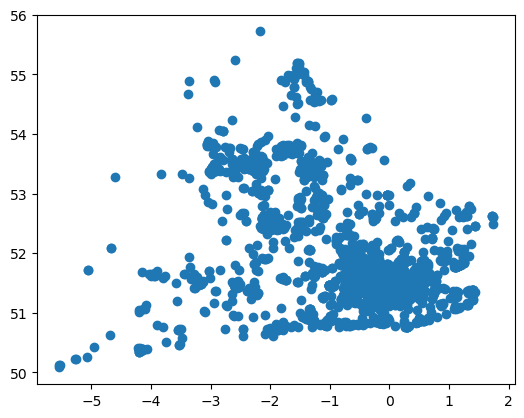

In [5]:
# Identifying points

# Create a GeoDataFrame from the DataFrame
crimepoints = gpd.GeoDataFrame(crimepoints, geometry=gpd.points_from_xy(crimepoints['Longitude'], crimepoints['Latitude']))

# Plot the points. It is noticed that the points dataset covers all the UK.
crimepoints.plot()


In [6]:
# Reading in the 2021 dataset from Project 1 (former CrimeMap_2021)

London_Map_2021 = gpd.read_file('London_Map_2021.geojson')

# Selection of relevant columns
London_Map_2021 = London_Map_2021 [['LSOA Code', 'OA21CD','LSOA21NM','BNG_E','BNG_N','LAT','LONG','GlobalID','2021 Crime/1000 people','2021 Population','2021 Non UK Percentage','Elementary Sum 2021','Elementary Prop 2021','geometry']]
London_Map_2021.head(5)

LSOA Code     OA21CD                   LSOA21NM   BNG_E   BNG_N      LAT  \
0  E01000001  E00000001        City of London 001A  532250  181864  51.5202   
1  E01000002  E00000018        City of London 001B  532397  181793  51.5195   
2  E01000003  E00000010        City of London 001C  532092  182114  51.5225   
3  E01000005  E00000029        City of London 001E  533581  181249  51.5144   
4  E01000006  E00000049  Barking and Dagenham 016A  544816  184464  51.5405   

       LONG                              GlobalID  2021 Crime/1000 people  \
0 -0.095230  09af0f57-ef7c-448b-b0ba-093649a86e70              121.109608   
1 -0.093140  b9862ded-2d5e-4f2f-9009-951bb8f6ecae              176.555716   
2 -0.097410  eee105a5-6df7-41b7-ba8e-d77deb24493f               50.216987   
3 -0.076290  a5689649-6253-4357-b84c-9fe07fedf0c6              463.570128   
4  0.086831  148eca51-307b-43e3-a746-8ded9845dabf               51.031488   

   2021 Population  2021 Non UK Percentage  Elementary Sum 2021  \
0             1478                0.408660                   34   
1             1382                0.450796                   15   
2             1613                0.429014                   95   
3             1098                0.485428                  172   
4             1842                0.517915                  311   

   Elementary Prop 2021                                           geometry  
0              0.039171  POLYGON ((532275.938 181637.750, 532272.750 18...  
1              0.017143  POLYGON ((532624.323 181842.310, 532626.495 18...  
2              0.094810  POLYGON ((532236.500 181891.563, 532224.624 18...  
3              0.348178  POLYGON ((533615.622 181406.023, 533619.062 18...  
4              0.351016  POLYGON ((545183.927 184145.062, 545179.170 18...

In [7]:
# Check the CRS of the crimepoints dataset
print(crimepoints.crs)
print(London_Map_2021.crs)

# Changing the crs of points from non to EPSG:4326 (latitud and longitud)
crimepoints.crs = 'EPSG:4326'

print(crimepoints.crs)


None
EPSG:27700
EPSG:4326


In [8]:
# Reproject points to EPSG 27700. This had to be done so that the points align with the LSOA polygons.
crimepoints_reprojected = crimepoints.to_crs(London_Map_2021.crs)

In [9]:
# As I mentiond before the points were for all UK, so I performed a spatial join to determine which LSOA each point belongs to
London_Crime_Points = gpd.sjoin(crimepoints_reprojected, London_Map_2021, op='within')
London_Crime_Points = London_Crime_Points.reset_index(drop=True)

# This reduces the dataset to only the geometry of the points. This might keep it simple to calculate distances.
Crime_Points_GeomOnly = London_Crime_Points[['geometry']]


c:\Users\Mark\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
# View of the points within London Only

London_Crime_Points.head(5)

Crime ID    Month  \
0  59263678a3b555ff49b56c8139a50ae7d726319ad11696...  2021-03   
1                                                NaN  2021-03   
2                                                NaN  2021-03   
3                                                NaN  2021-03   
4  032c65a78e935a164f4dc13877de2364976669a77cbc82...  2021-03   

                   Reported by                 Falls within  Longitude  \
0        City of London Police        City of London Police  -0.126375   
1  Metropolitan Police Service  Metropolitan Police Service  -0.126375   
2  Metropolitan Police Service  Metropolitan Police Service  -0.126699   
3  Metropolitan Police Service  Metropolitan Police Service  -0.122678   
4  Metropolitan Police Service  Metropolitan Police Service  -0.123643   

    Latitude                      Location  LSOA code    LSOA name  \
0  51.531512      On or near Shopping Area  E01000953  Camden 022B   
1  51.531512      On or near Shopping Area  E01000953  Camden 022B   
2  51.533442          On or near Goods Way  E01000953  Camden 022B   
3  51.535167     On or near Petrol Station  E01000953  Camden 022B   
4  51.530264  On or near Pedestrian Subway  E01000953  Camden 022B   

                     Crime type  ...   BNG_E   BNG_N      LAT     LONG  \
0  Violence and sexual offences  ...  530110  183405  51.5346 -0.12548   
1         Anti-social behaviour  ...  530110  183405  51.5346 -0.12548   
2         Anti-social behaviour  ...  530110  183405  51.5346 -0.12548   
3         Anti-social behaviour  ...  530110  183405  51.5346 -0.12548   
4                 Bicycle theft  ...  530110  183405  51.5346 -0.12548   

                               GlobalID 2021 Crime/1000 people  \
0  83efcc5c-f476-4407-ab32-44af3d213115             184.008201   
1  83efcc5c-f476-4407-ab32-44af3d213115             184.008201   
2  83efcc5c-f476-4407-ab32-44af3d213115             184.008201   
3  83efcc5c-f476-4407-ab32-44af3d213115             184.008201   
4  83efcc5c-f476-4407-ab32-44af3d213115             184.008201   

  2021 Population  2021 Non UK Percentage  Elementary Sum 2021  \
0            1951                0.583803                  102   
1            1951                0.583803                  102   
2            1951                0.583803                  102   
3            1951                0.583803                  102   
4            1951                0.583803                  102   

   Elementary Prop 2021  
0              0.136913  
1              0.136913  
2              0.136913  
3              0.136913  
4              0.136913  

[5 rows x 27 columns]

In [11]:
# This is the geometry of the crime points

Crime_Points_GeomOnly.head(5)

geometry
0  POINT (530058.981 183063.966)
1  POINT (530058.981 183063.966)
2  POINT (530031.014 183278.014)
3  POINT (530304.970 183476.989)
4  POINT (530252.028 182930.040)

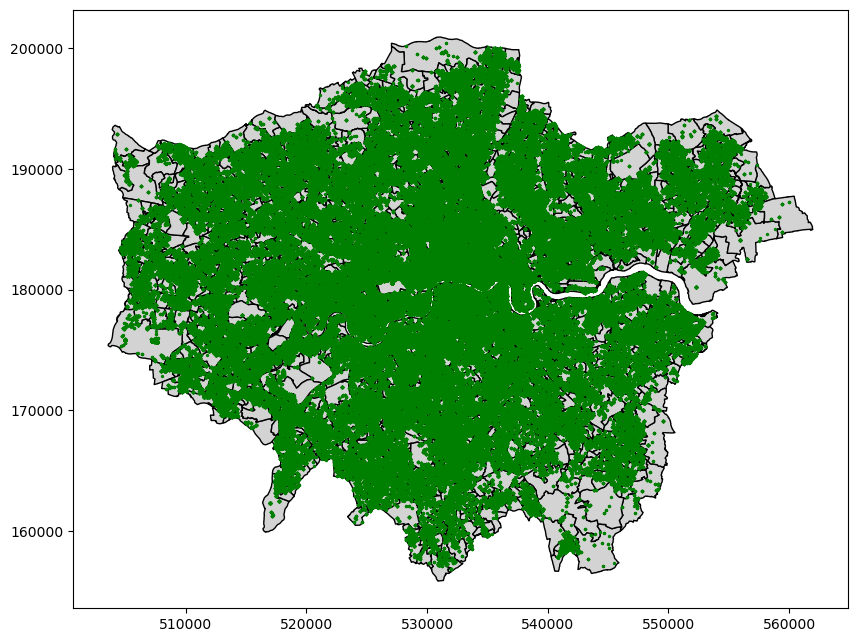

In [12]:
# Map to show that polygons and points are in the right format. THIS IS JUST A CHECK. 
fig, ax = plt.subplots(figsize=(10, 10))
London_Map_2021.plot(ax=ax, color='lightgrey', edgecolor='black')
Crime_Points_GeomOnly.plot(ax=ax, color='green',markersize=2)
plt.show()


### Education/Qualification Data

In [13]:
#Load London all 7 2021 education levels and numbers of 16+ persons, per LSOA 
Edu_2021 = pd.read_excel('London2021_Qualifications.xlsx', sheet_name= '2021')
Edu_2021 = Edu_2021 [['LSOA code', 'Usual residents aged 16+','none','Level 1','Level 2','Apprentice-ship','Level 3','Level 4+','Other']]
Edu_2021 = Edu_2021.rename(columns={'LSOA code': 'LSOA Code'})


In [15]:
Edu_2021.head()

LSOA Code  Usual residents aged 16+  none  Level 1  Level 2  \
0  E01000001                      1353    32       26       54   
1  E01000002                      1300    23       28       52   
2  E01000003                      1505   132       61       90   
3  E01000005                       958   197       61      122   
4  E01000006                      1429   295      155      170   

   Apprentice-ship  Level 3  Level 4+  Other  
0               13       86      1126     16  
1                4       89      1086     18  
2               12      121      1055     34  
3               32      130       387     29  
4               38      206       499     66

In [16]:
#merge London education levels with the London map
London_Map_2021 = London_Map_2021.merge(Edu_2021, on = 'LSOA Code', how='outer' )
London_Map_2021['Level0_1'] = London_Map_2021['none'] + London_Map_2021['Level 1']



In [17]:
London_Map_2021.head()

LSOA Code     OA21CD                   LSOA21NM   BNG_E   BNG_N      LAT  \
0  E01000001  E00000001        City of London 001A  532250  181864  51.5202   
1  E01000002  E00000018        City of London 001B  532397  181793  51.5195   
2  E01000003  E00000010        City of London 001C  532092  182114  51.5225   
3  E01000005  E00000029        City of London 001E  533581  181249  51.5144   
4  E01000006  E00000049  Barking and Dagenham 016A  544816  184464  51.5405   

       LONG                              GlobalID  2021 Crime/1000 people  \
0 -0.095230  09af0f57-ef7c-448b-b0ba-093649a86e70              121.109608   
1 -0.093140  b9862ded-2d5e-4f2f-9009-951bb8f6ecae              176.555716   
2 -0.097410  eee105a5-6df7-41b7-ba8e-d77deb24493f               50.216987   
3 -0.076290  a5689649-6253-4357-b84c-9fe07fedf0c6              463.570128   
4  0.086831  148eca51-307b-43e3-a746-8ded9845dabf               51.031488   

   2021 Population  ...                                           geometry  \
0             1478  ...  POLYGON ((532275.938 181637.750, 532272.750 18...   
1             1382  ...  POLYGON ((532624.323 181842.310, 532626.495 18...   
2             1613  ...  POLYGON ((532236.500 181891.563, 532224.624 18...   
3             1098  ...  POLYGON ((533615.622 181406.023, 533619.062 18...   
4             1842  ...  POLYGON ((545183.927 184145.062, 545179.170 18...   

   Usual residents aged 16+  none Level 1  Level 2  Apprentice-ship  Level 3  \
0                      1353    32      26       54               13       86   
1                      1300    23      28       52                4       89   
2                      1505   132      61       90               12      121   
3                       958   197      61      122               32      130   
4                      1429   295     155      170               38      206   

   Level 4+  Other  Level0_1  
0      1126     16        58  
1      1086     18        51  
2      1055     34       193  
3       387     29       258  
4       499     66       450  

[5 rows x 23 columns]

In [18]:
##getting number of people with different qualification levels per 1000 people (to line up with Crime rates)
London_Map_2021['No qualification/1000 people'] = (London_Map_2021['none']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Level 1/1000 people'] = (London_Map_2021['Level 1']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Level0_1/1000 people'] = (London_Map_2021['Level0_1']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Level 2/1000 people'] = (London_Map_2021['Level 2']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Level 3/1000 people'] = (London_Map_2021['Level 3']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Level 4/1000 people'] = (London_Map_2021['Level 4+']/(London_Map_2021['Usual residents aged 16+'])*1000)
London_Map_2021['Apprenticeship/1000 people'] = (London_Map_2021['Apprentice-ship']/(London_Map_2021['Usual residents aged 16+'])*1000)

London_Map_2021.head()

qualification_values = [
    ('London_Map_2021_no_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['No qualification/1000 people']), 3)),
    ('London_Map_2021_level1_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Level 1/1000 people']), 3)),
    ('London_Map_2021_level0_1_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Level0_1/1000 people']), 3)),
    ('London_Map_2021_level2_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Level 2/1000 people']), 3)),
    ('London_Map_2021_level3_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Level 3/1000 people']), 3)),
    ('London_Map_2021_level4_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Level 4/1000 people']), 3)),
    ('London_Map_2021_Apprenticeship_qualification', round(London_Map_2021['2021 Crime/1000 people'].corr(London_Map_2021['Apprenticeship/1000 people']), 3))
]

for variable, value in qualification_values:
    print(f"{variable}: {value}")


London_Map_2021_no_qualification: -0.031
London_Map_2021_level1_qualification: -0.111
London_Map_2021_level0_1_qualification: -0.059
London_Map_2021_level2_qualification: -0.196
London_Map_2021_level3_qualification: -0.034
London_Map_2021_level4_qualification: 0.094
London_Map_2021_Apprenticeship_qualification: -0.116


### Spatial Correlation Analysis

In [126]:
# Creation of Spatial Weight Matrix (W) from the London_Map_2021
w = weights.Queen.from_dataframe(London_Map_2021)
# Row-standardization
w.transform = 'R'

C:\Users\FSzeliga\AppData\Local\Temp\ipykernel_22036\2594347835.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(London_Map_2021)


#### Spatial Lag 

In [127]:
# Calculation of spatial lag

London_Map_2021_SpatialCorr = London_Map_2021.copy() # Creating a copy just in case
London_Map_2021_SpatialCorr['CrimeRate_Lag'] = weights.spatial_lag.lag_spatial(w, London_Map_2021_SpatialCorr['2021 Crime/1000 people'])

Text(0.5, 1.0, 'Spatial Lag: 2021 London Crime Rate by LSOA')

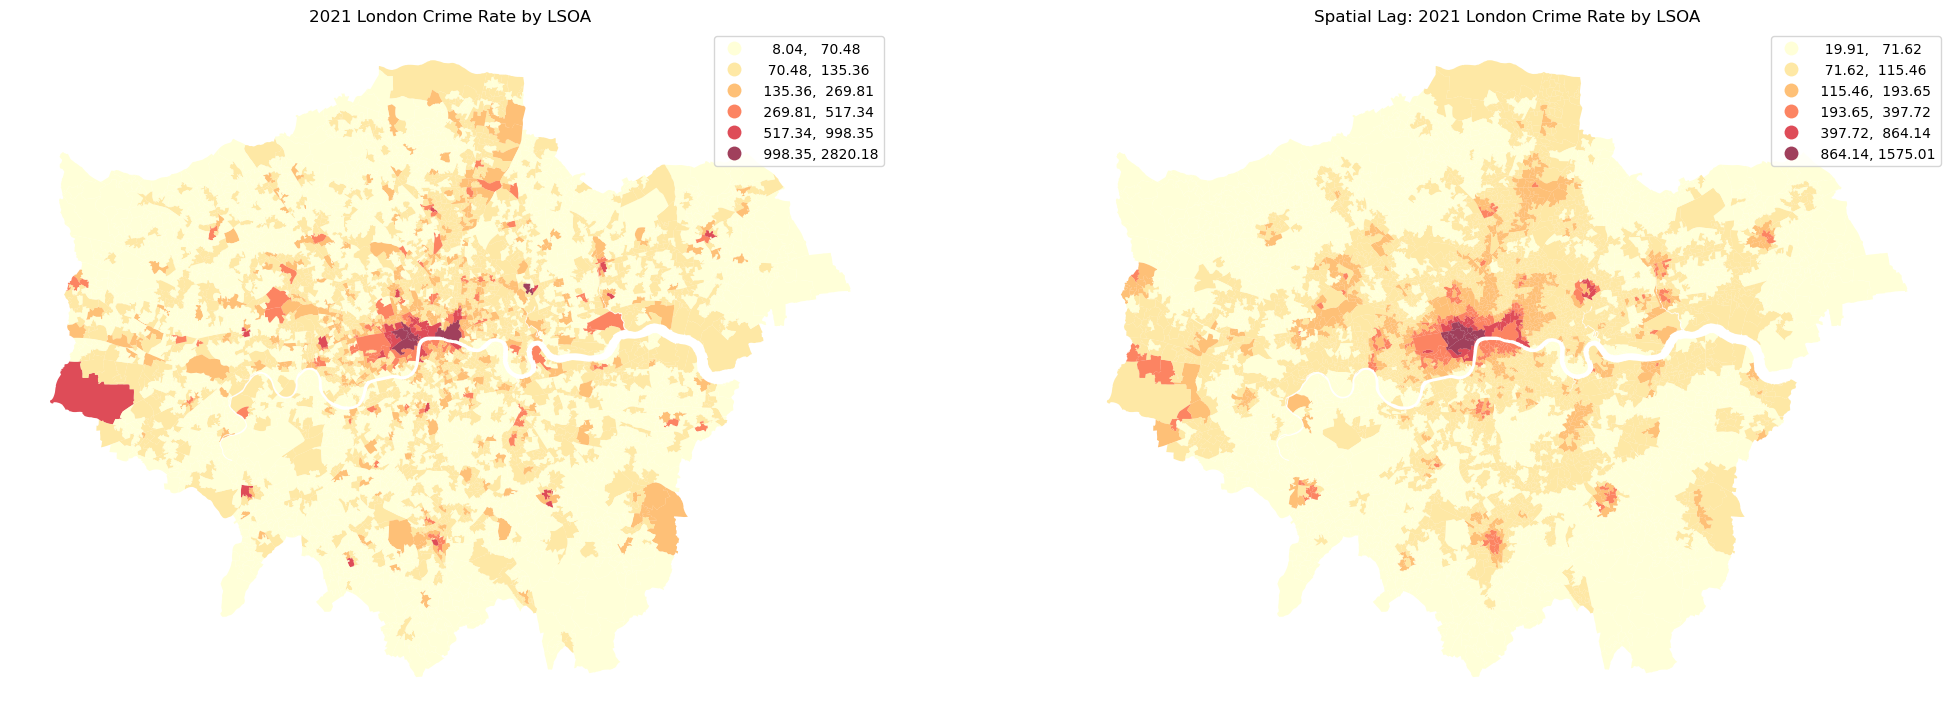

In [128]:
# Ploting the original crime rate values and the spatial lag values side by side

f, axs = plt.subplots(1, 2, figsize=(25, 20))
ax1, ax2 = axs

London_Map_2021_SpatialCorr.to_crs('EPSG:3857').plot(column='2021 Crime/1000 people', cmap='YlOrRd', scheme='FisherJenks',
        k=6, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("2021 London Crime Rate by LSOA")
#cx.add_basemap(ax1, source=cx.providers.CartoDB.Voyager)

London_Map_2021_SpatialCorr.to_crs('EPSG:3857').plot(column='CrimeRate_Lag', cmap='YlOrRd', scheme='FisherJenks',
        k=6, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("Spatial Lag: 2021 London Crime Rate by LSOA")
#cx.add_basemap(ax2, source=cx.providers.CartoDB.Voyager)

<Axes: xlabel='High', ylabel='2021 Crime/1000 people'>

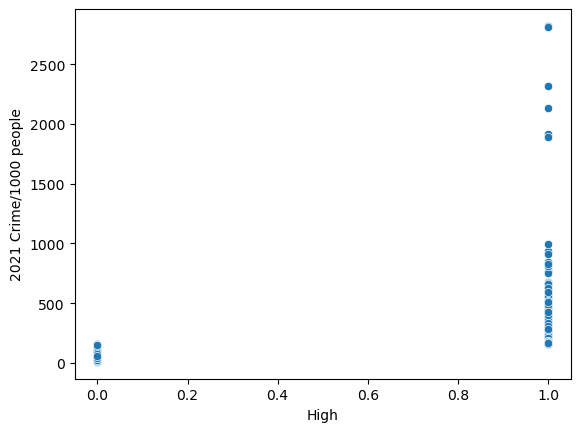

In [129]:
# Classification of High crime rate values. I selected 157 as a threshold as this represents the upper whisker of the boxplot in the previous project. 
London_Map_2021_SpatialCorr['High'] = (London_Map_2021_SpatialCorr['2021 Crime/1000 people'] > 157).astype(int)
seaborn.scatterplot(data=London_Map_2021_SpatialCorr, x="High", y="2021 Crime/1000 people")

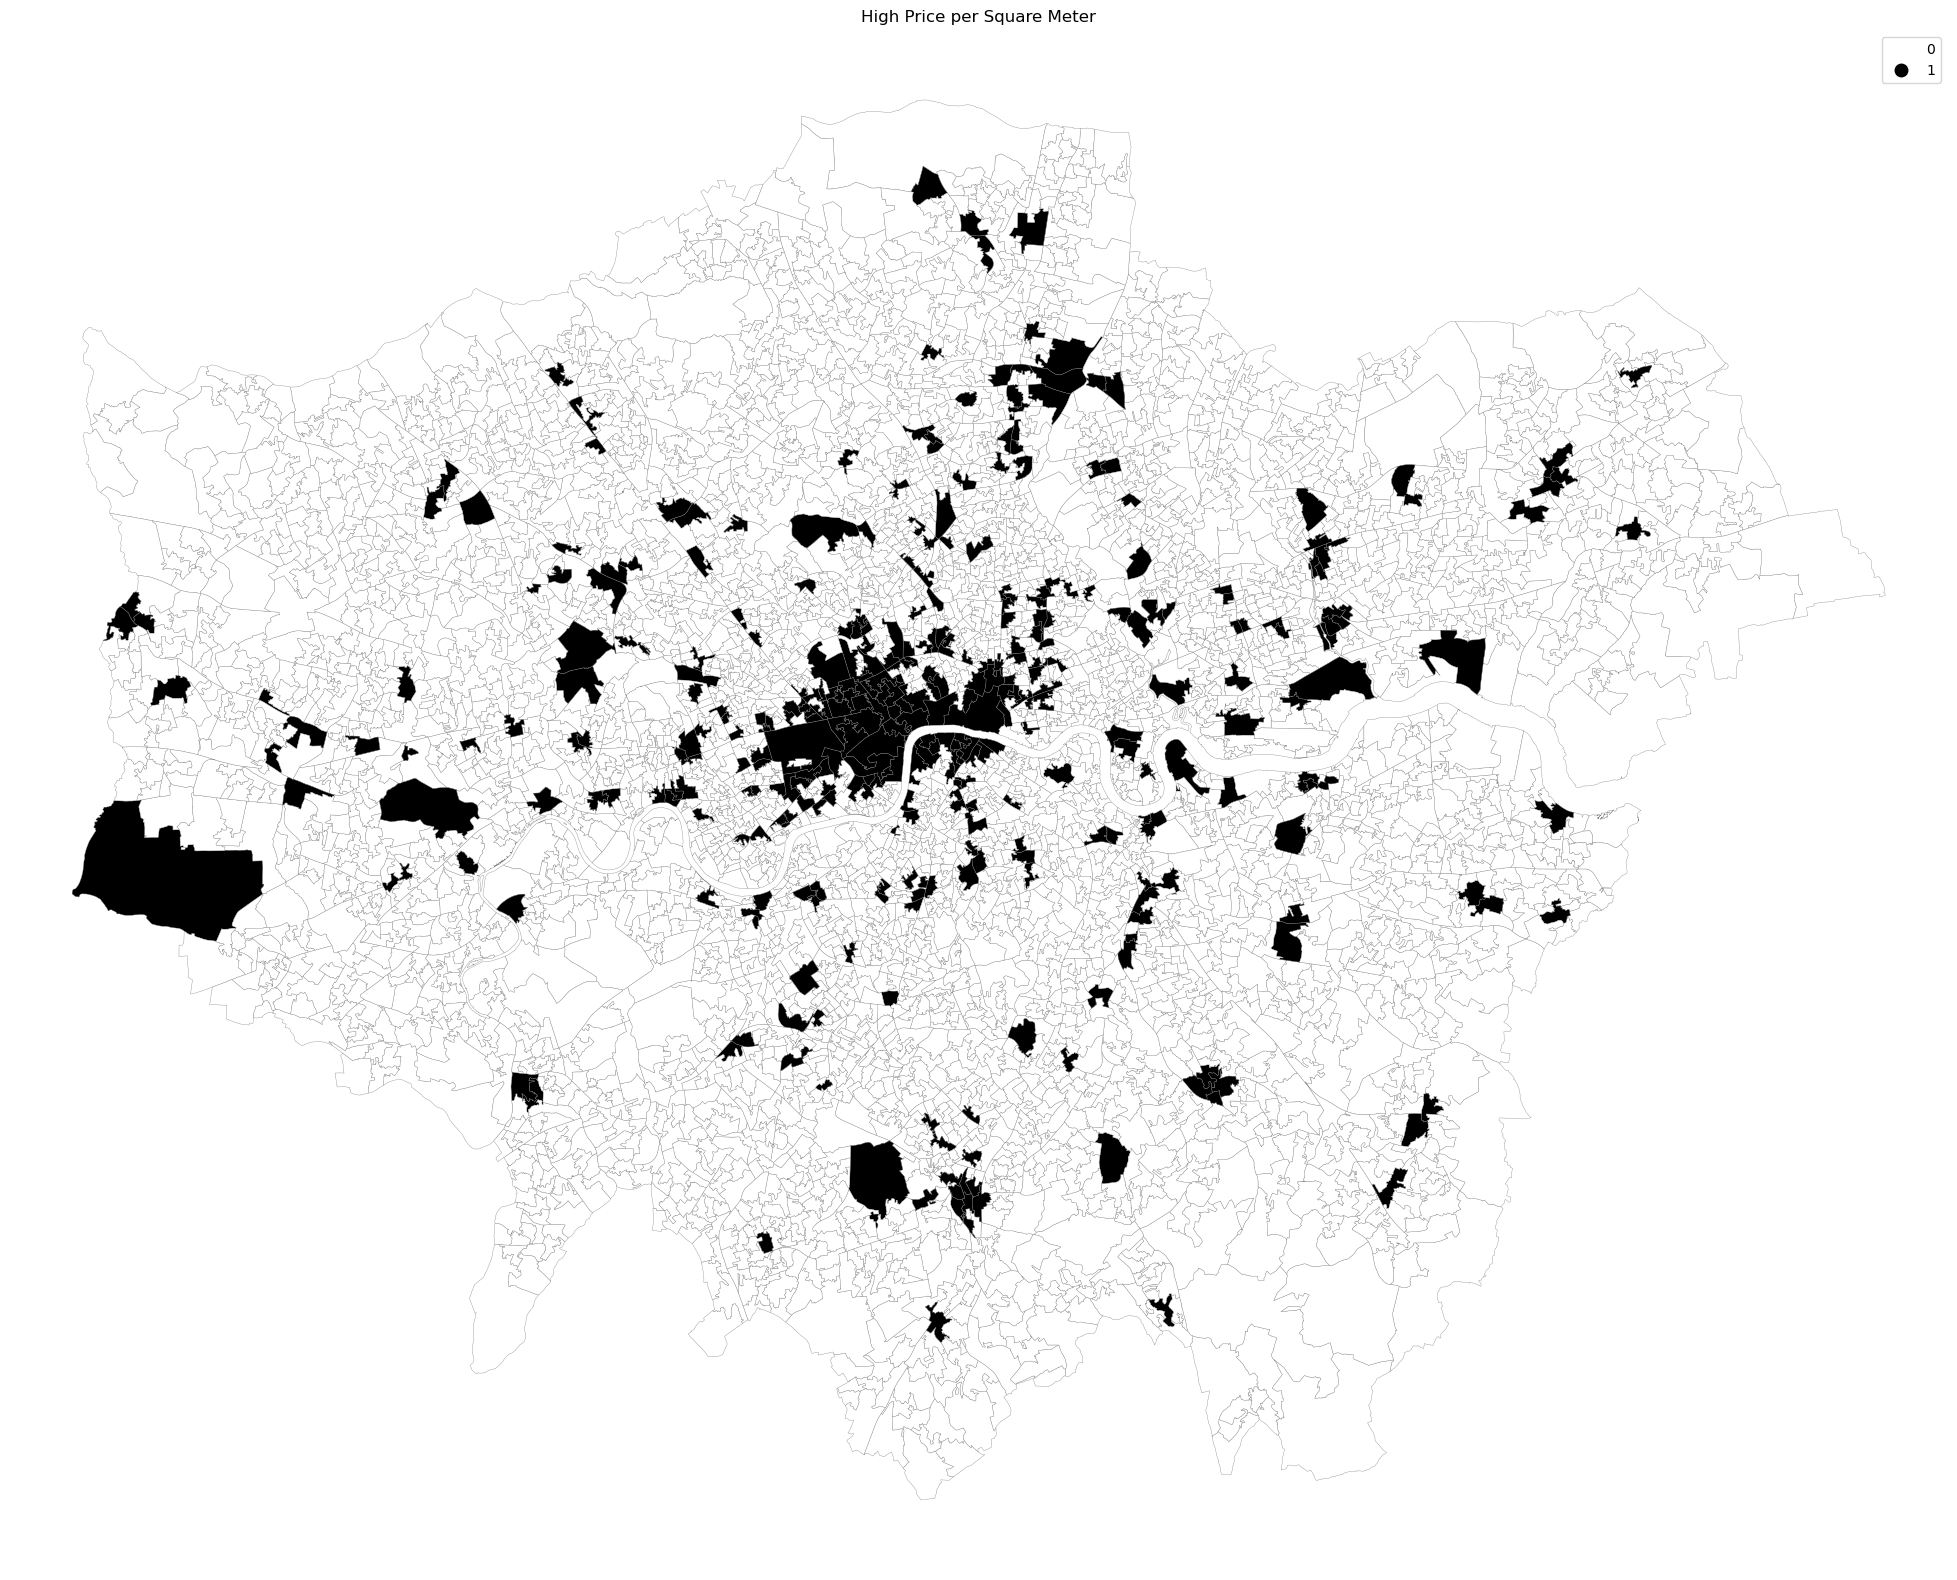

In [130]:
f, ax = plt.subplots(1, figsize=(25, 20))
London_Map_2021_SpatialCorr.plot(ax=ax, column='High', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Greys');
ax.set_axis_off()
ax.set_title('High Price per Square Meter')
plt.axis('equal')
plt.show()

In [131]:
w.transform = 'O' #Transform weights matrix back to non-standardized state in order to sum total counts
jc = esda.join_counts.Join_Counts(London_Map_2021_SpatialCorr['High'], w)

In [132]:
# Count of black - black joints 

jc.bb

341.0

In [133]:
# Count of white - white joints 

jc.ww

12589.0

In [134]:
# Count of black-white joints

jc.bw

1804.0

In [135]:
# Number of rows in the dataset
len(London_Map_2021_SpatialCorr)

4994

In [136]:
# 14791/4994 = 2.96 ~ 3 neighbours per observation

jc.bb + jc.ww + jc.bw

14734.0

In [137]:
# expected value of black-black joints

jc.mean_bb

79.16516516516516

In [138]:
# expecteed value of black-white joints

jc.mean_bw

2006.3933933933934

In [139]:
# Statistical significance, we reject H0: black and white LSOAs are randonly distributed

jc.p_sim_bb

0.001

#### Moran's I

In [140]:
# Start by standarasing the variables in terms of units of standard deviation

London_Map_2021_SpatialCorr['CR_std'] = ( London_Map_2021_SpatialCorr['2021 Crime/1000 people'] - London_Map_2021_SpatialCorr['2021 Crime/1000 people'].mean() )\
                    / London_Map_2021_SpatialCorr['2021 Crime/1000 people'].std()
London_Map_2021_SpatialCorr['CR_lag_std'] = ( London_Map_2021_SpatialCorr['CrimeRate_Lag'] - London_Map_2021_SpatialCorr['CrimeRate_Lag'].mean() )\
                    / London_Map_2021_SpatialCorr['CrimeRate_Lag'].std()

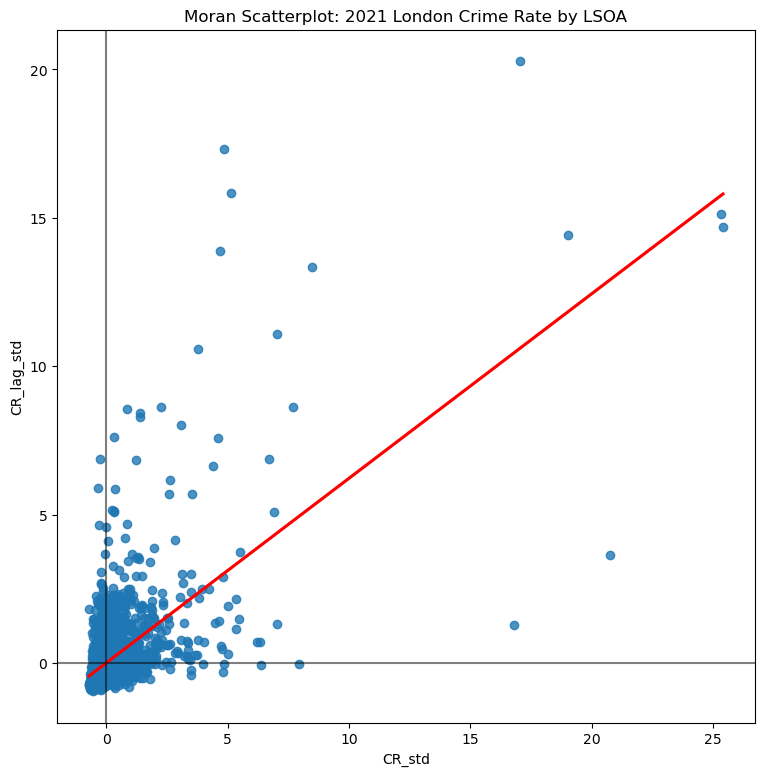

In [141]:
# Moran Scatterplot 

f, ax = plt.subplots(1, figsize=(9, 9))

seaborn.regplot(x='CR_std', y='CR_lag_std', 
                ci=None, data=London_Map_2021_SpatialCorr, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Scatterplot: 2021 London Crime Rate by LSOA')
plt.show()

In [142]:
# Calculation of Moran's I value

w.transform = 'R' # back to standarised values
moran = esda.Moran(London_Map_2021_SpatialCorr['2021 Crime/1000 people'], w)
moran.I

0.4231991409916195

In [143]:
# Calculation of statistical significance - p-value

moran.p_sim

0.001

C:\Users\FSzeliga\AppData\Local\Temp\ipykernel_22036\3947482095.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(moran.sim, shade=True)
c:\Users\FSzeliga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.1, 0.5)

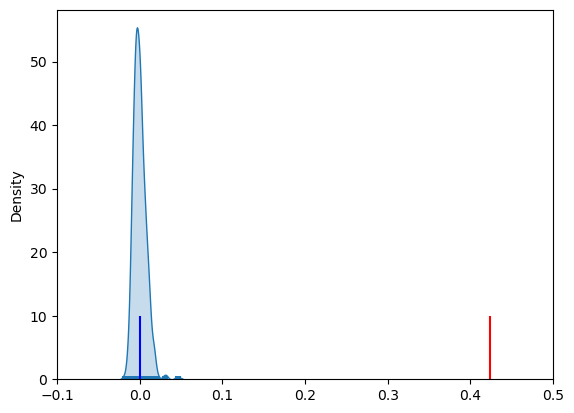

In [144]:
seaborn.kdeplot(moran.sim, shade=True)
plt.vlines(moran.sim, 0, 0.5)
plt.vlines(moran.I, 0, 10, 'red')
plt.vlines(moran.EI, 0, 10, 'blue') #Expected value of I
plt.xlim([-0.1, 0.5])

#### LISA Analysis

In [145]:
# Calculation of Local Moran's I

moran_loc = Moran_Local(London_Map_2021_SpatialCorr['2021 Crime/1000 people'], w, permutations=9999)

In [146]:
# Testing FDA

moran_values = moran_loc.Is
p_values = moran_loc.p_sim
London_Map_2021_SpatialCorr['moran_values']= moran_values
London_Map_2021_SpatialCorr['LISA p-values']= p_values
London_Map_2021_FDR = London_Map_2021_SpatialCorr
London_Map_2021_FDR = London_Map_2021_FDR.sort_values(by='LISA p-values', ascending=True)
London_Map_2021_FDR['i'] = London_Map_2021_FDR.reset_index().index+1
London_Map_2021_FDR['FDR'] = (London_Map_2021_FDR['i']/len(London_Map_2021_FDR)) * 0.01
London_Map_2021_FDR.head(5)


LSOA Code     OA21CD                   LSOA21NM   BNG_E   BNG_N  \
4502  E01004761  E00024109           Westminster 018D  528556  180447   
2782  E01002926  E00014708  Kingston upon Thames 010B  519553  167598   
757   E01000790  E00003849               Bromley 028C  545944  165687   
4461  E01004715  E00023812           Westminster 013A  528809  182012   
2155  E01002265  E00011289              Havering 025A  553380  184951   

          LAT      LONG                              GlobalID  \
4502  51.5083 -0.148960  8f2c8089-6c69-436a-92f5-6dc1645c960f   
2782  51.3948 -0.282960  4a486a84-ecb3-40be-a73c-95513838cb37   
757   51.3715  0.095342  3dc40d22-f6da-4850-82d2-ef18a4045b45   
4461  51.5223 -0.144740  6c3c364b-5531-4304-9d2a-34f8d1a1eb12   
2155  51.5426  0.210437  a09f145e-42c0-4383-92c7-ad25d5660c50   

      2021 Crime/1000 people  2021 Population  ...  Level 4/1000 people  \
4502              998.351195             1213  ...           664.879357   
2782               18.147685             1598  ...           559.157212   
757               188.071397             2297  ...           512.435233   
4461              216.335541             1812  ...           581.962218   
2155               39.021164             1512  ...           268.921095   

      Apprenticeship/1000 people  CrimeRate_Lag High    CR_std  CR_lag_std  \
4502                   29.490617    1067.017421    1  8.484158   13.346405   
2782                   26.742301      35.972990    0 -0.621267   -0.731055   
757                    27.979275      29.606505    1  0.957209   -0.817981   
4461                   15.234613     589.859234    1  1.219764    6.831482   
2155                   58.776167      32.260541    0 -0.427367   -0.781744   

      moran_values  LISA p-values  i       FDR  
4502     77.392666         0.0001  1  0.000002  
2782      0.283100         0.0001  2  0.000004  
757      -0.492793         0.0001  3  0.000006  
4461      5.720136         0.0001  4  0.000008  
2155      0.209482         0.0001  5  0.000010  

[5 rows x 36 columns]

In [147]:
# FDA Retuls - There is no significant retuls using FDA

London_Map_2021_FDR['FDR Check'] = London_Map_2021_FDR['LISA p-values'] < London_Map_2021_FDR['FDR']
(London_Map_2021_FDR['FDR Check'] == True).sum()

15

In [148]:
# Testing Bonferroni Method

# Number of observations
n = 4994

# Desired family-wise error rate
alpha = 0.05

# Bonferroni corrected significance level
bonferroni_alpha = alpha / n
bonferroni_alpha

1.0012014417300761e-05

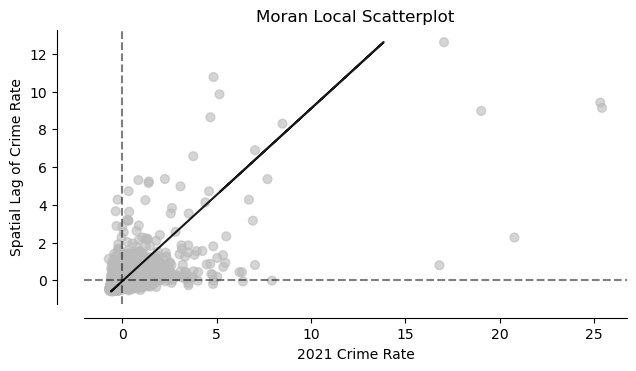

In [149]:
# As the numeber of observations is too high, no results are significant

f, ax = moran_scatterplot(moran_loc, p=bonferroni_alpha)
ax.set_xlabel('2021 Crime Rate')
ax.set_ylabel('Spatial Lag of Crime Rate')
plt.show()

##### alpha = 0.01

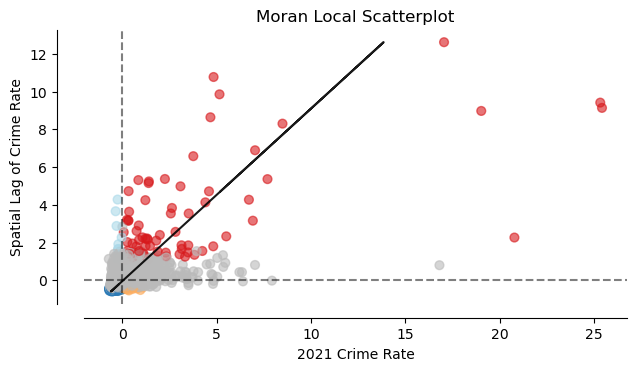

In [150]:
f, ax = moran_scatterplot(moran_loc, p=0.01)
ax.set_xlabel('2021 Crime Rate')
ax.set_ylabel('Spatial Lag of Crime Rate')
plt.show()

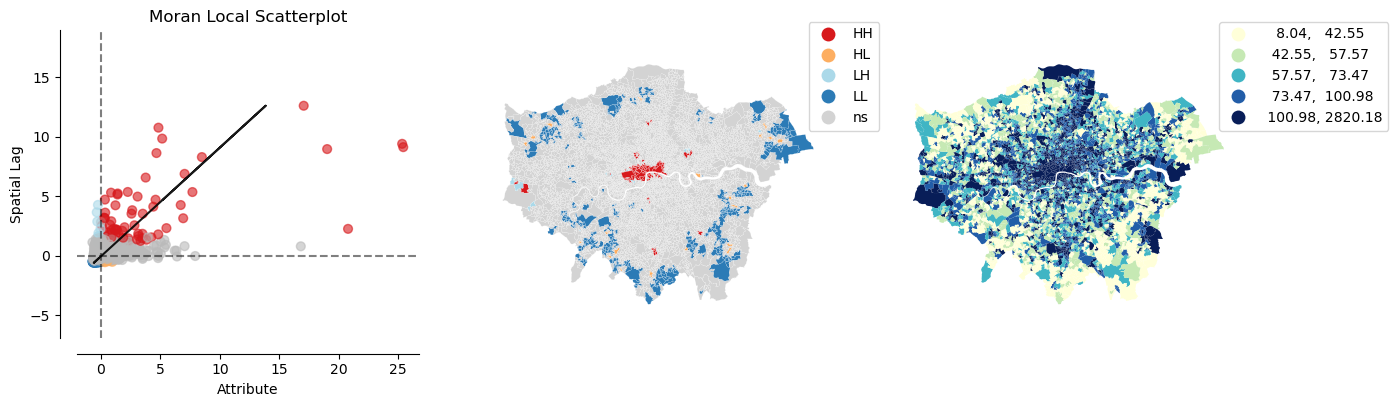

In [151]:
plot_local_autocorrelation(moran_loc, London_Map_2021_SpatialCorr, '2021 Crime/1000 people', p=0.01)
plt.show()

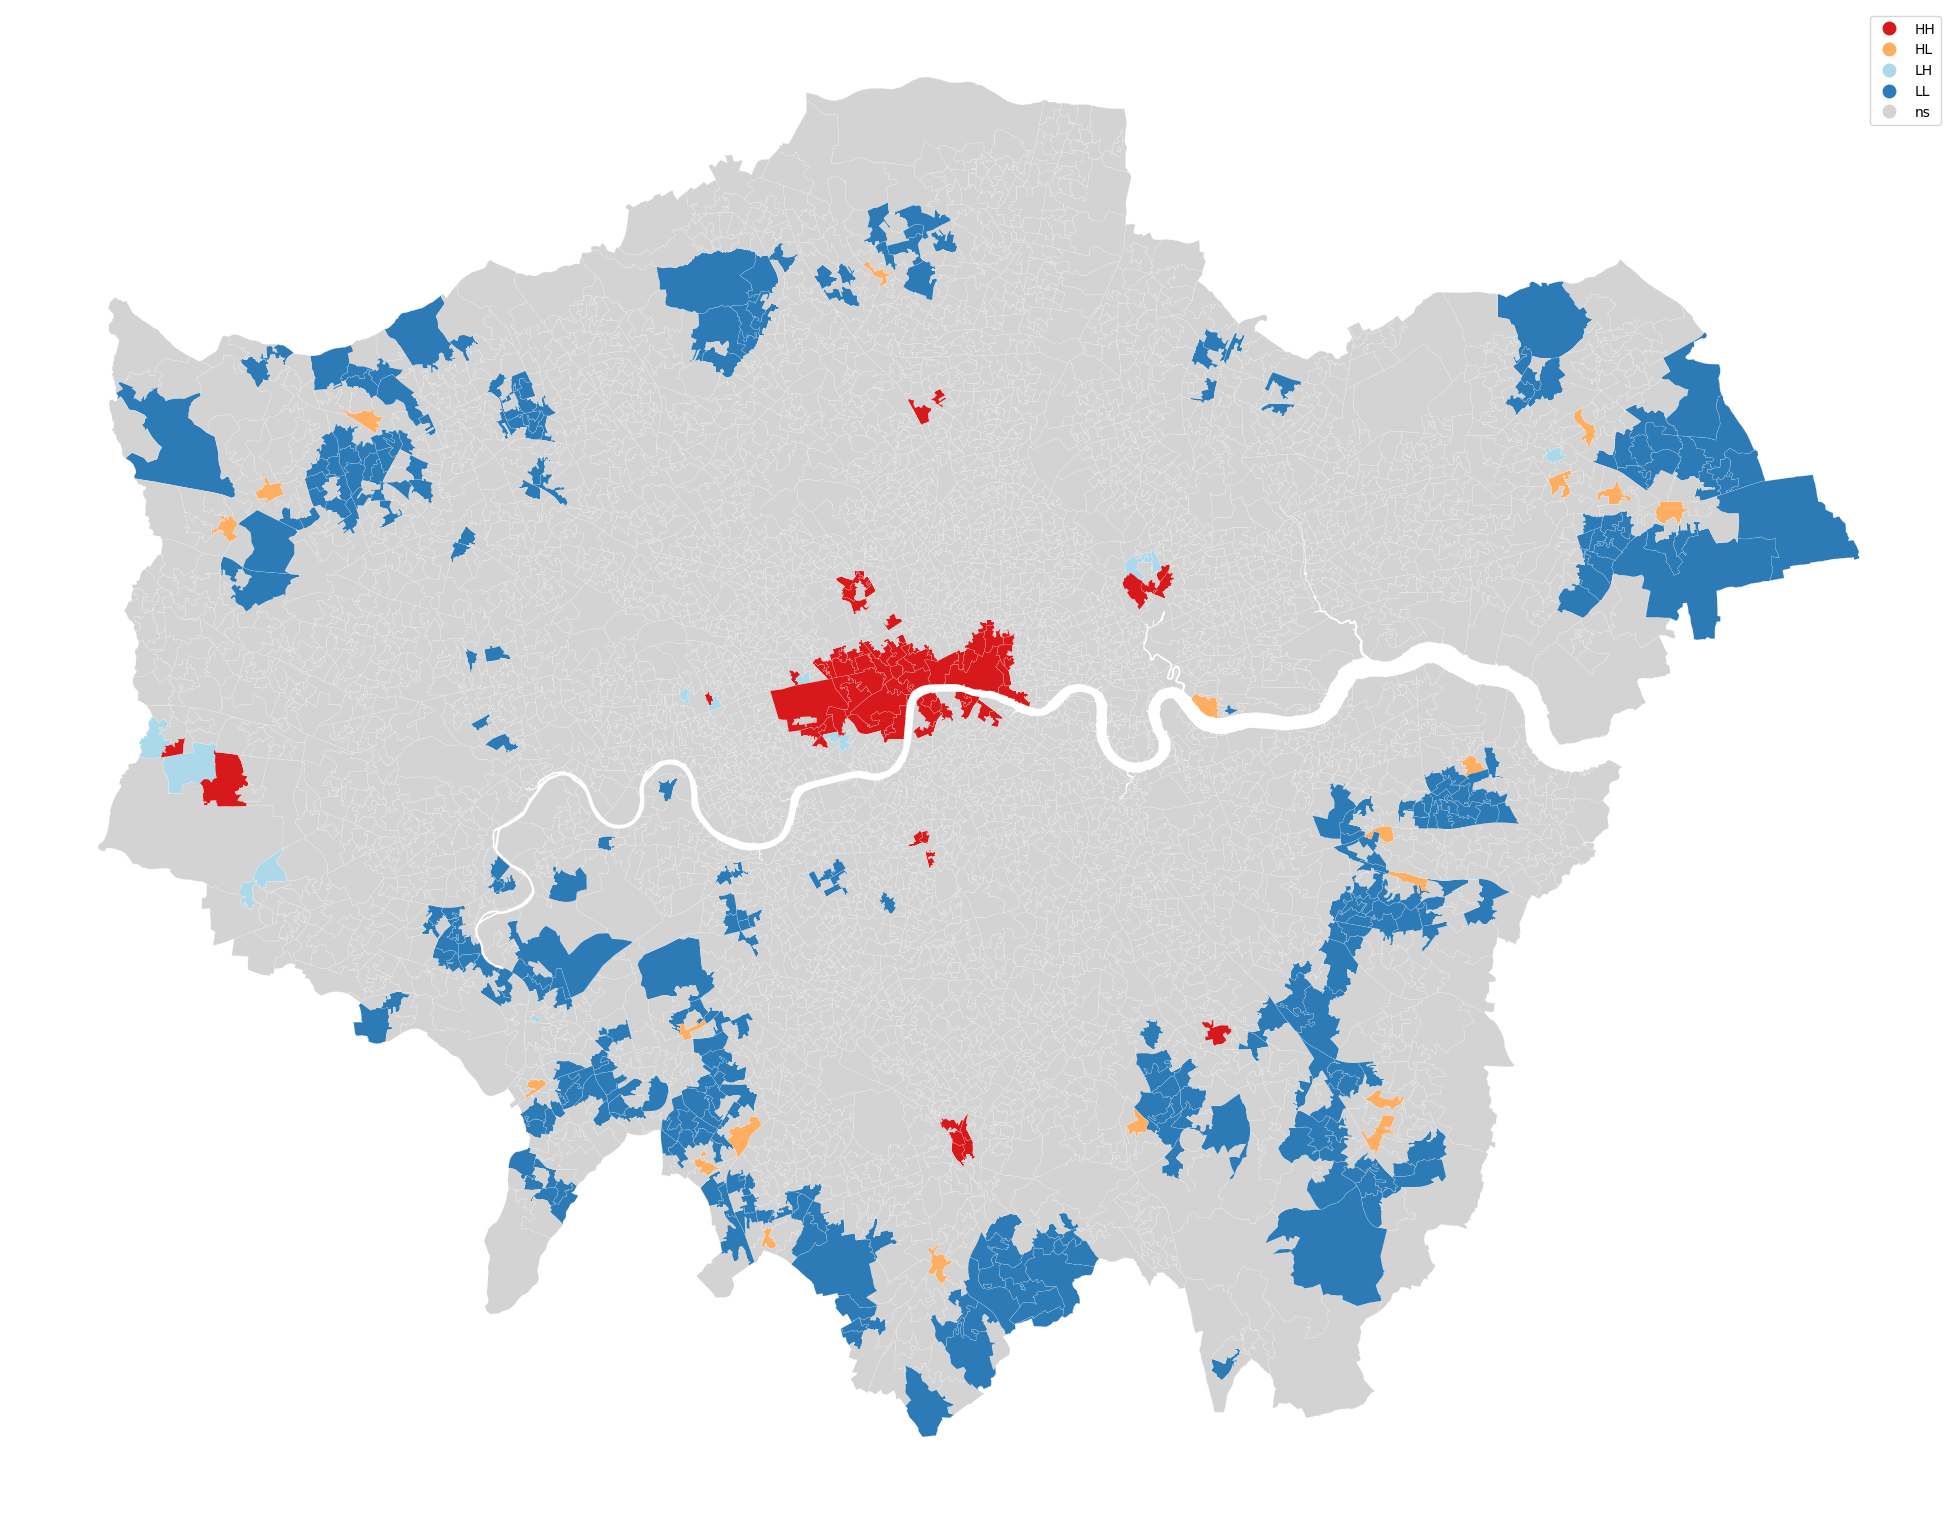

In [152]:
lisa_cluster(moran_loc, London_Map_2021_SpatialCorr, p=0.01, figsize = (25,20))
plt.show()

p-value = 0.1

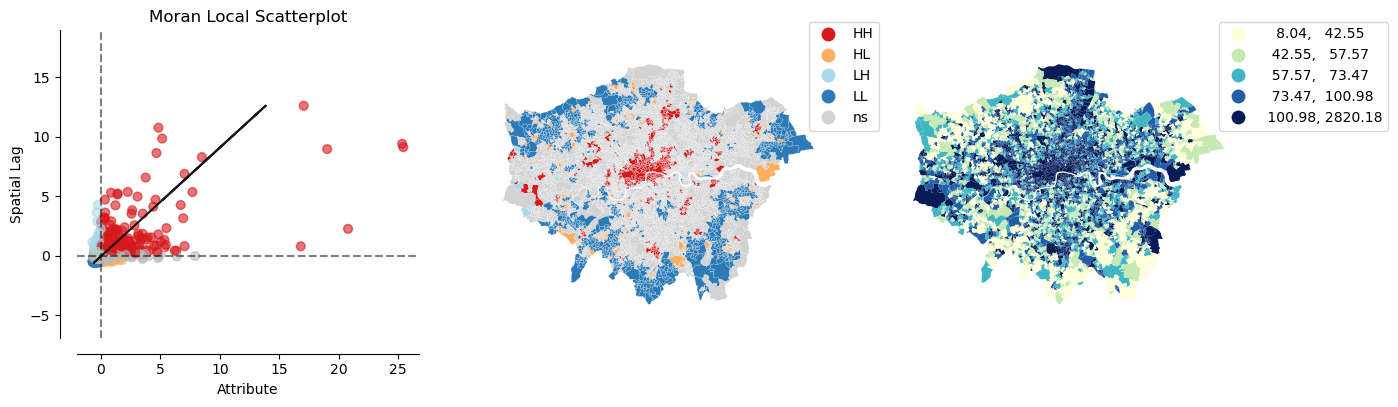

In [153]:
plot_local_autocorrelation(moran_loc, London_Map_2021_SpatialCorr, '2021 Crime/1000 people', p=0.1)
plt.show()

p-value = 0.05

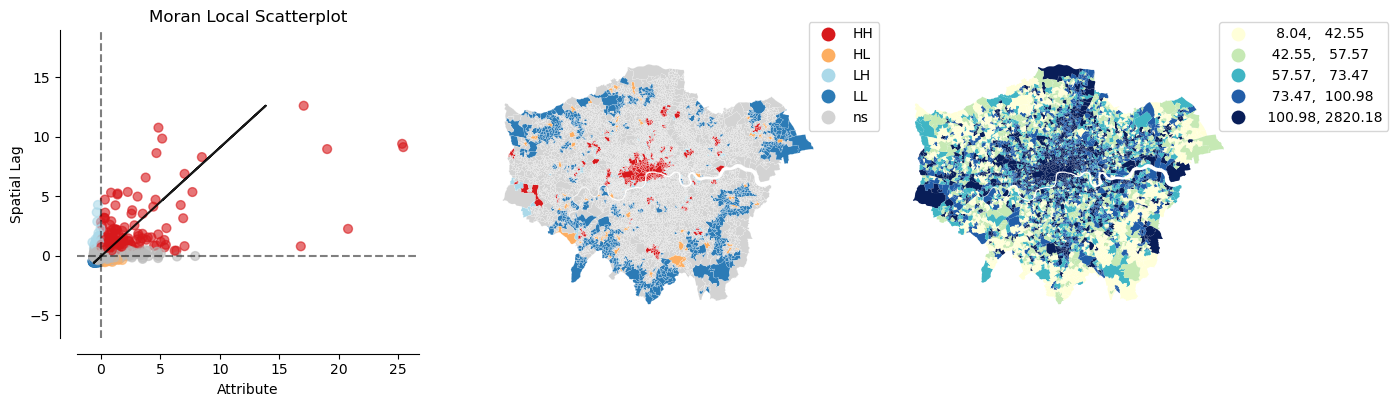

In [154]:
plot_local_autocorrelation(moran_loc, London_Map_2021_SpatialCorr, '2021 Crime/1000 people', p=0.05)
plt.show()

p-value = 0.001

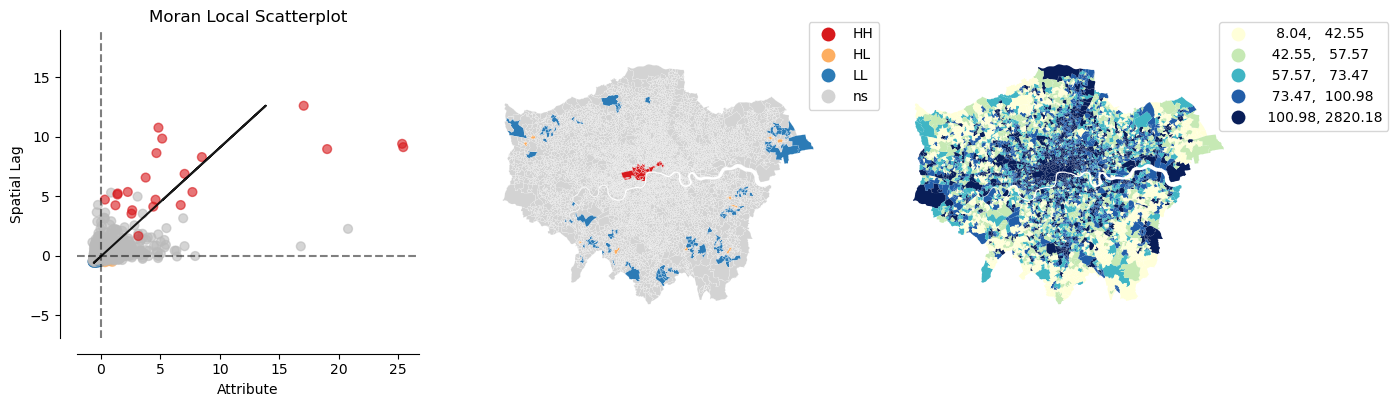

In [155]:
plot_local_autocorrelation(moran_loc, London_Map_2021_SpatialCorr, '2021 Crime/1000 people', p=0.001)
plt.show()

### Exploratory Spatial Regression Model